In [8]:
from arcpy import *
from arcpy import env
from arcpy.sa import *
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from datetime import datetime
from math import sqrt
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
import time, random
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib import rcParams
import rasterio
from rasterio.transform import from_origin
from rasterio.plot import show
import rioxarray as rio
from PIL import Image
from sklearn.model_selection import train_test_split
import math

In [9]:
def nash_sutcliffe_efficiency(observed, simulated):
    numerator = np.sum((observed - simulated)**2)
    denominator = np.sum((observed - np.mean(observed))**2)
    nse = 1 - (numerator / denominator)
    return nse

def mean_bias(observed, simulated):
    mb = np.mean(simulated - observed)
    return mb

def root_mean_squared_error(observed, simulated):
    rmse = np.sqrt(np.mean((observed - simulated)**2))
    return rmse

def normalized_mean_bias(observed, simulated):
    nmb = np.sum(simulated - observed) / np.sum(observed)
    return nmb

def normalized_mean_error(observed, simulated):
    nme = np.sum(np.abs(simulated - observed)) / np.sum(observed)
    return nme

def coefficient_of_determination(observed, simulated):
    numerator = np.sum((observed - simulated)**2)
    denominator = np.sum((observed - np.mean(observed))**2)
    r_squared = 1 - (numerator / denominator)
    return r_squared

def mean_absolute_error(observed, predicted):
    mae = np.mean(np.abs(observed - predicted))
    return mae

def mean_absolute_percentage_error(observed, predicted):
    observed, predicted = np.array(observed), np.array(predicted)
    return np.mean(np.abs((observed - predicted) / observed)) * 100

def percent_bias(observed, simulated):
    """Calculate Percent Bias (PBIAS)"""
    pbias = 100 * np.sum(observed - simulated) / np.sum(observed)
    return pbias

def root_mean_square_error_ratio(observed, simulated):
    """Calculate Root Mean Square Error Ratio (RSR)"""
    mse = np.mean((simulated - observed)**2)
    observed_range = np.max(observed) - np.min(observed)
    rsr = np.sqrt(mse) / observed_range
    return rsr

def correlation_coefficient(observed, predicted):
    return np.corrcoef(observed, predicted)[0, 1]

In [10]:
day = 31; month_number = "03"; month_name = "March"
BIG_DATA_PREPROCESSING_PATH = "G:/Big_Data_Preprocessing"
MODULE_EXECUTION_PATH = "G:/Model_Execution"
CALIBRATION_PATH = BIG_DATA_PREPROCESSING_PATH + "/Air/Concentration/Calibration"
path_CMAQ = f"{MODULE_EXECUTION_PATH}/CMAQ_Libraries/"
path_MCIP = f"{MODULE_EXECUTION_PATH}/MCIP_Libraries/MET_Oregon_{month_number}01/"
# path_Thucdo = "Output/REAL_DATA/"
data_MCIP = xr.open_dataset(path_MCIP + "GRIDCRO2D_110702.nc")

In [11]:
COOR_LAT = data_MCIP['LAT']
COOR_LON = data_MCIP['LON']
df = COOR_LAT.to_dataframe(name="value")
df_reset = df.reset_index()
rows_per_sheet = 1000000
num_sheets = len(df_reset) // rows_per_sheet + 1
excel_file_path = f"{CALIBRATION_PATH}/Result/2_Excel/COORLAT.xlsx"
with pd.ExcelWriter(excel_file_path) as writer:
    for i in range(num_sheets):
        start_row = i * rows_per_sheet
        end_row = min((i + 1) * rows_per_sheet, len(df_reset))
        df_reset.iloc[start_row:end_row].to_excel(writer, sheet_name=f"Sheet{i+1}", index=False)

df = COOR_LON.to_dataframe(name="value")
df_reset = df.reset_index()
rows_per_sheet = 1000000
num_sheets = len(df_reset) // rows_per_sheet + 1
excel_file_path = f"{CALIBRATION_PATH}/Result/2_Excel/COORLON.xlsx"
with pd.ExcelWriter(excel_file_path) as writer:
    for i in range(num_sheets):
        start_row = i * rows_per_sheet
        end_row = min((i + 1) * rows_per_sheet, len(df_reset))
        df_reset.iloc[start_row:end_row].to_excel(writer, sheet_name=f"Sheet{i+1}", index=False)

In [12]:
path_excel_ground = fr"{CALIBRATION_PATH}/Result/0_Initial_Data/Observed_Data_{month_name}.xlsx"
data_excel_file = pd.ExcelFile(path_excel_ground)
stations = data_excel_file.sheet_names
print(stations)

['Pendleton - McKay Cr', 'Portland - SE Lafaye', 'Portland - Sauvie Is', 'Portland - Spangler', 'Portland Near Road', 'John Day Dayton St', 'Grants Pass - Parksi', 'Klamath Falls - Pete', 'Albany - Calapooia S', 'Lakeview - Center &', 'Baker City - Forest', 'Beaverton - Highland', 'Turner - CJHS', 'Hermiston - Municipa', 'Madras - Westside Sc', 'Talent - Rapp Lane', 'Sweet Home - Fire De', 'Cave Junction Forest', 'Sisters Forest Servi', 'Silverton', 'Shady Cove - Shady C', 'Cottage Grove City S', 'Salem - State Hospit', 'Eugene - Amazon Park', 'Oakridge - Willamett', 'Roosevelt High Schoo', 'Portland Lane Middle', 'Portland Lincoln Hig', 'Portland SE 12th and', 'Portland McDaniel Hi', 'Enterprise - US Fore', 'Ashland Fire Dept', 'Sunriver Three River', 'Bend Pine Ridge Elem', 'Bend Ponderosa Eleme', 'Salem Chemeketa Comm', 'Toledo NE Hwy20 & NW', 'Woodburn Chemeketa C', 'Corvallis EPA Office', 'Tillamook Jr High Sc', 'McMinnville High Sch', 'Portland Humboldt Sc', 'Detroit Lake', 'Chil

In [13]:
data_real_df = {}
for station in stations:
    data_real_df[station] = pd.read_excel(f'{CALIBRATION_PATH}/Result/0_Initial_Data/Data_Predict_{month_name}.xlsx', sheet_name=station, index_col=0)
data_real_df[stations[0]].head()

,PM25_RH35_GCC,CLDTT,PS,Q10M,RH,T10M,TPREC,TROPPB,TS,U10M,V10M,ZPBL,PM25_Average,PM25_Predict
0,1.25783,0.772461,93947.101562,0.002987,0.581301,275.710999,5.560000e-07,34814.000000,273.093994,-0.507178,-0.235227,93.737602,1.257830,7.619667
1,1.44034,0.554688,93994.898438,0.002903,0.601046,275.014008,8.428470e-08,34824.199219,270.123993,-0.853105,-0.640173,90.455704,1.349085,10.235700
2,1.60014,0.565430,94041.101562,0.002914,0.622676,274.661011,2.112940e-08,34984.000000,269.483002,-0.896840,-0.770607,86.812599,1.432770,10.206000
3,1.82716,0.507812,94089.601562,0.002941,0.644151,274.454987,1.372250e-08,36536.601562,269.177002,-0.534342,-0.771505,81.822998,1.531368,10.092500
4,2.22659,0.395020,94183.796875,0.002971,0.668616,274.175995,1.261650e-08,36687.898438,269.027008,0.319512,-0.650851,86.544296,1.773557,8.235533


In [14]:
column = []; data = []; column_df = ['LON', 'LAT']; index_to_exclude = []
column_df_hourly = ['LON', 'LAT']; data_hourly = []
for index in range(1, day+1, 1):
    column_df.append(str(index).zfill(2) + month_number)
    for hour in range(0, 24, 1):
        column_df_hourly.append(str(index).zfill(2) + f"{month_number}-{str(hour).zfill(2)}h")
        data_hourly.append(np.nan)
    column.append(str(index).zfill(2) + month_number)
    data.append(np.nan)
data.append(np.nan); data.append(np.nan)
data_hourly.append(np.nan); data_hourly.append(np.nan)
PM25_datareal = pd.DataFrame(columns = column_df)
for index in range(len(stations)):
    if not index in index_to_exclude:
        PM25_datareal.loc[stations[index]] = data

PM25_datareal_Hourly = pd.DataFrame(columns = column_df_hourly)
for index in range(len(stations)):
    if not index in index_to_exclude:
        PM25_datareal_Hourly.loc[stations[index]] = data_hourly

In [15]:
stations = data_excel_file.sheet_names
for index in range(len(stations)):
    if not index in index_to_exclude:
        station = stations[index]
        data_excel = pd.read_excel(path_excel_ground, sheet_name=station, index_col="Unnamed: 0")
        data_day = data_excel.groupby('Day').mean()
        for index in data_day["PM2.5"].index:
            day = index; PM25_datareal.loc[station, str(day).zfill(2) + month_number] = data_day.loc[index, 'PM2.5']

        for index in data_excel["PM2.5"].index:
            hour = data_excel.loc[index, 'Hour']; day = data_excel.loc[index, 'Day']
            PM25_datareal_Hourly.loc[station, str(day).zfill(2) + f"{month_number}-{str(hour).zfill(2)}h"] = data_excel.loc[index, 'PM2.5']

In [16]:
coordinate = pd.read_csv(f'{CALIBRATION_PATH}/Result/0_Initial_Data/Coordinate_{month_name}.csv')
for index in coordinate.index:
    if not index in index_to_exclude:
        PM25_datareal.loc[stations[index], 'LON'] = coordinate.loc[index, 'Lon']
        PM25_datareal.loc[stations[index], 'LAT'] = coordinate.loc[index, 'Lat']
        PM25_datareal_Hourly.loc[stations[index], 'LON'] = coordinate.loc[index, 'Lon']
        PM25_datareal_Hourly.loc[stations[index], 'LAT'] = coordinate.loc[index, 'Lat']

In [17]:
for index in coordinate.index:
    if not index in index_to_exclude:
        station = stations[index]
        value = np.array([])
        value = np.append(value, PM25_datareal_Hourly.loc[station, 'LON'])
        value = np.append(value, PM25_datareal_Hourly.loc[station, 'LAT'])
        value = np.append(value, data_real_df[station]['PM25_Predict'].values)
        PM25_datareal_Hourly.loc[station] = value

In [18]:
# mask = f"{CALIBRATION_PATH}/Result/0_Initial_Data/Coordinate.shp"
# output_folder = f"{CALIBRATION_PATH}/Result/3_Value/"
# temp_folder = f"{CALIBRATION_PATH}/Result/Temp/"
# raster_path = f"{CALIBRATION_PATH}/Result/1_GeoTIFF/"
# os.makedirs(raster_path, exist_ok=True)
# arcpy.env.overwriteOutput = True
# arcpy.env.workspace = raster_path
# rasters = arcpy.ListRasters("*", "All")
# for raster in rasters:
#     parts = raster.split('_')
#     date = parts[1]+'_'+parts[2][:-5]; raster_tiff = os.path.join(raster_path, raster)
#     ExtractValuesToPoints(mask, raster_tiff, temp_folder + "Extract_Point")
#     arcpy.conversion.TableToExcel(temp_folder + "Extract_Point.shp", output_folder + f"PM25_{date}.xlsx")

In [19]:
PM25_datamodel = pd.DataFrame(columns = ['LON', 'LAT'] + column)
PM25_datamodel_Hourly = pd.DataFrame(columns = column_df_hourly)
for index in range(len(stations)):
    if not index in index_to_exclude:
        station = stations[index]
        PM25_datamodel.loc[station] = PM25_datareal.loc[station]
        PM25_datamodel_Hourly.loc[station] = PM25_datareal_Hourly.loc[station]

In [20]:
path_excel = f"{CALIBRATION_PATH}/Result/3_Value"
excel_files = os.listdir(path_excel); value = np.array([])
for excel_file in excel_files:
    if (excel_file.endswith(".xlsx")):
        parts = excel_file.split('_'); df_excel = pd.read_excel(f"{path_excel}/{excel_file}")
        day = str(parts[1][0:2]).zfill(2); month = str(parts[1][2:4]).zfill(2); hour = str(parts[2][0:2]).zfill(2)
        value_excel = []
        for index in range(df_excel["RASTERVALU"].size):
            if not index in index_to_exclude:
                value_excel = np.append(value_excel, df_excel.loc[index, "RASTERVALU"])
        if (value.size == 0):
            value = value_excel
        else:
            value = value + value_excel
        if (hour == "23"):
            PM25_datamodel[day+month] = value/24
            value = np.array([])
        for index in range(df_excel["RASTERVALU"].size):
            if not index in index_to_exclude:
                PM25_datamodel_Hourly.loc[df_excel.loc[index, "Stations"], day+month+'-'+hour+'h'] = df_excel.loc[index, "RASTERVALU"]

In [21]:
df_multiplier = pd.DataFrame(columns = PM25_datareal_Hourly.columns[2:])
for column_multiplier in df_multiplier.columns:
    day = int(column_multiplier[0:2])
    x = PM25_datareal_Hourly[column_multiplier].mean()
    y = PM25_datamodel_Hourly[column_multiplier].mean()
    df_multiplier.loc['Observed Mean', column_multiplier] = x
    df_multiplier.loc['Simulated Mean', column_multiplier] = y
    df_multiplier.loc['Multiplier', column_multiplier] = x/y
    if (math.isnan(x)):
        df_multiplier.drop(columns=[column_multiplier], inplace=True)
print(df_multiplier)

from warnings import simplefilter
warnings.simplefilter(action='ignore', category=FutureWarning)
PM25_df_hieuchinh = PM25_datamodel_Hourly.copy()
for column_name in df_multiplier.columns[2:]:
    for station in PM25_datareal_Hourly.index:
        x = (PM25_datamodel_Hourly.loc[station, column_name]*
             df_multiplier.loc['Multiplier', column_name])
        PM25_df_hieuchinh.loc[station, column_name] = x
print(PM25_df_hieuchinh)

                 0103-00h   0103-01h   0103-02h   0103-03h   0103-04h  \
Observed Mean    6.440437    6.12805   6.328824   6.851739   6.841848   
Simulated Mean   0.506589   0.417229   0.319402   0.296987   0.280316   
Multiplier      12.713347  14.687505  19.814595  23.070812  24.407656   

                 0103-05h   0103-06h   0103-07h   0103-08h   0103-09h  ...  \
Observed Mean    6.456427   6.375934   6.319596   6.084667   6.027079  ...   
Simulated Mean   0.269538   0.221081   0.196738   0.173626   0.155803  ...   
Multiplier      23.953649  28.839746  32.121834  35.044749  38.684002  ...   

                 3103-14h  3103-15h   3103-16h   3103-17h   3103-18h  \
Observed Mean    2.377768  2.329177   2.226198   2.304332   2.417016   
Simulated Mean   0.125582  0.130972   0.138947   0.142878   0.141419   
Multiplier      18.933981  17.78381  16.021944  16.127974  17.091211   

                 3103-19h  3103-20h   3103-21h   3103-22h   3103-23h  
Observed Mean    2.443122   2.5465

In [22]:
simulated_data = []
observed_data = []
for column in PM25_datareal_Hourly.columns[2:]:
    for index in PM25_datareal_Hourly.index:
        if not np.isnan(PM25_datareal_Hourly.loc[index, column]):
            observed_data.append(PM25_datareal_Hourly.loc[index, column])
            simulated_data.append(PM25_df_hieuchinh.loc[index, column])

In [23]:
stations = PM25_df_hieuchinh.index
num_stations = len(stations)
num_train = int(num_stations*0.8)
num_test = num_stations - num_train
index_train = random.sample(range(num_stations), num_train)
index_test = np.delete(np.arange(num_stations), index_train)
stations_train = stations[index_train]
stations_test = stations[index_test]

In [24]:
simulated_df_train = PM25_df_hieuchinh.loc[stations_train]
simulated_df_train = simulated_df_train[simulated_df_train.columns[2:]]
simulated_df_test = PM25_df_hieuchinh.loc[stations_test]
simulated_df_test = simulated_df_test[simulated_df_test.columns[2:]]
real_df_train = PM25_datareal_Hourly.loc[stations_train]
real_df_train = real_df_train[real_df_train.columns[2:]]
real_df_test = PM25_datareal_Hourly.loc[stations_test]
real_df_test = real_df_test[real_df_test.columns[2:]]

In [25]:
simulated_data_train = {}
simulated_data_test = {}
real_data_train = {}
real_data_test = {}

In [26]:
simulated_data_verify = np.array([])
observed_data_verify = np.array([])
for column_day in real_df_train.columns:
    for index in real_df_train.index:
        if (not math.isnan(real_df_train.loc[index, column_day])):
            simulated_data = np.append(simulated_data_verify, simulated_df_train.loc[index, column_day])
            simulated_data_verify = np.append(simulated_data_verify, simulated_df_train.loc[index, column_day])
            observed_data_verify = np.append(observed_data_verify, real_df_train.loc[index, column_day])

In [27]:
the_change = []
for index in range(observed_data_verify.size):
    if (abs(observed_data_verify[index]-simulated_data_verify[index]) > 0):
        the_change.append(index)

[0.81560791 0.4678675  0.53450426 ... 2.0634364  1.93366836 1.87562513] 0 1.2
----------------------------------------------------------------------------------------------------
[1.04094428 0.51538513 0.62466135 ... 1.81521986 1.56992389 1.52360148] 3.44147931595448 0.13003501789872898
----------------------------------------------------------------------------------------------------
[1.15659478 0.66382932 0.73780736 ... 1.56105523 1.81311821 1.7062368 ] 3.238819794069453 0.18662132559837016
----------------------------------------------------------------------------------------------------
[1.38184449 0.73148355 0.84639597 ... 1.9507964  2.12109734 1.43092519] 3.0404046092925103 0.24269652719602788
----------------------------------------------------------------------------------------------------
[1.89066982 0.8663951  1.06815096 ... 1.69314939 1.90318147 1.59781345] 2.8558231325805554 0.29527094967300666
-----------------------------------------------------------------------------

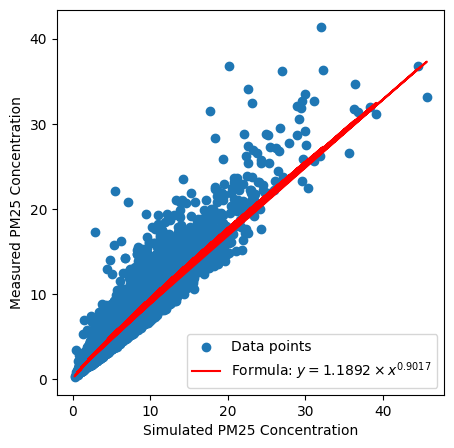

In [28]:
rcParams['figure.figsize'] = 5,5

a, b = 0, 1.2
while (True):
    while (b >= 1 or b < 0.9 or a < 1 or a > 2):
        for i in the_change:
            random_number = random.uniform(2, 10)
            if (simulated_data[i] > observed_data_verify[i]):
                simulated_data[i] = simulated_data[i] - simulated_data[i]/random_number
            elif (simulated_data[i] < observed_data_verify[i]):
                simulated_data[i] = simulated_data[i] + simulated_data[i]/random_number


        print(simulated_data, a, b)
        print('-'*100)
        x = simulated_data
        y = observed_data_verify
        log_x = np.log(x)
        log_y = np.log(y)
        model = LinearRegression().fit(log_x.reshape(-1, 1), log_y)
        slope = model.coef_[0]
        intercept = model.intercept_
        a = np.exp(intercept)
        b = slope

    y_pred = a * x**b
    r_squared_function = r2_score(y, y_pred)
    r_squared = r2_score(observed_data_verify, a * simulated_data_verify ** b)

    break
        
df_average = pd.DataFrame({'Average_Sim': simulated_data_verify, 'Average_Obs': observed_data_verify})

plt.scatter(x, y, label='Data points')
plt.plot(x, y_pred, color='red', label=f'Formula: $y = {a:.4f} \\times x^{{{b:.4f}}}$')
plt.xlabel('Simulated PM25 Concentration')
plt.ylabel('Measured PM25 Concentration')
plt.legend()
print(f'The coefficients of the power function: a = {a}, b = {b}')
print(f'R^2 Function: {r_squared_function}')
plt.savefig(f'{CALIBRATION_PATH}/Result/4_Diagram/Function.png')
plt.show(); plt.close()

In [29]:
simulated_data_verify = {}
observed_data_verify = {}
for index in real_df_test:
    simulated_data_verify[index] = np.array([])
    observed_data_verify[index] = np.array([])
for column_day in real_df_test.columns:
    for index in real_df_test.index:
        if (not math.isnan(real_df_test.loc[index, column_day])):
            simulated_data_verify[index] = np.append(simulated_data_verify, simulated_df_test.loc[index, column_day])
            observed_data_verify[index] = np.append(observed_data_verify, real_df_test.loc[index, column_day])

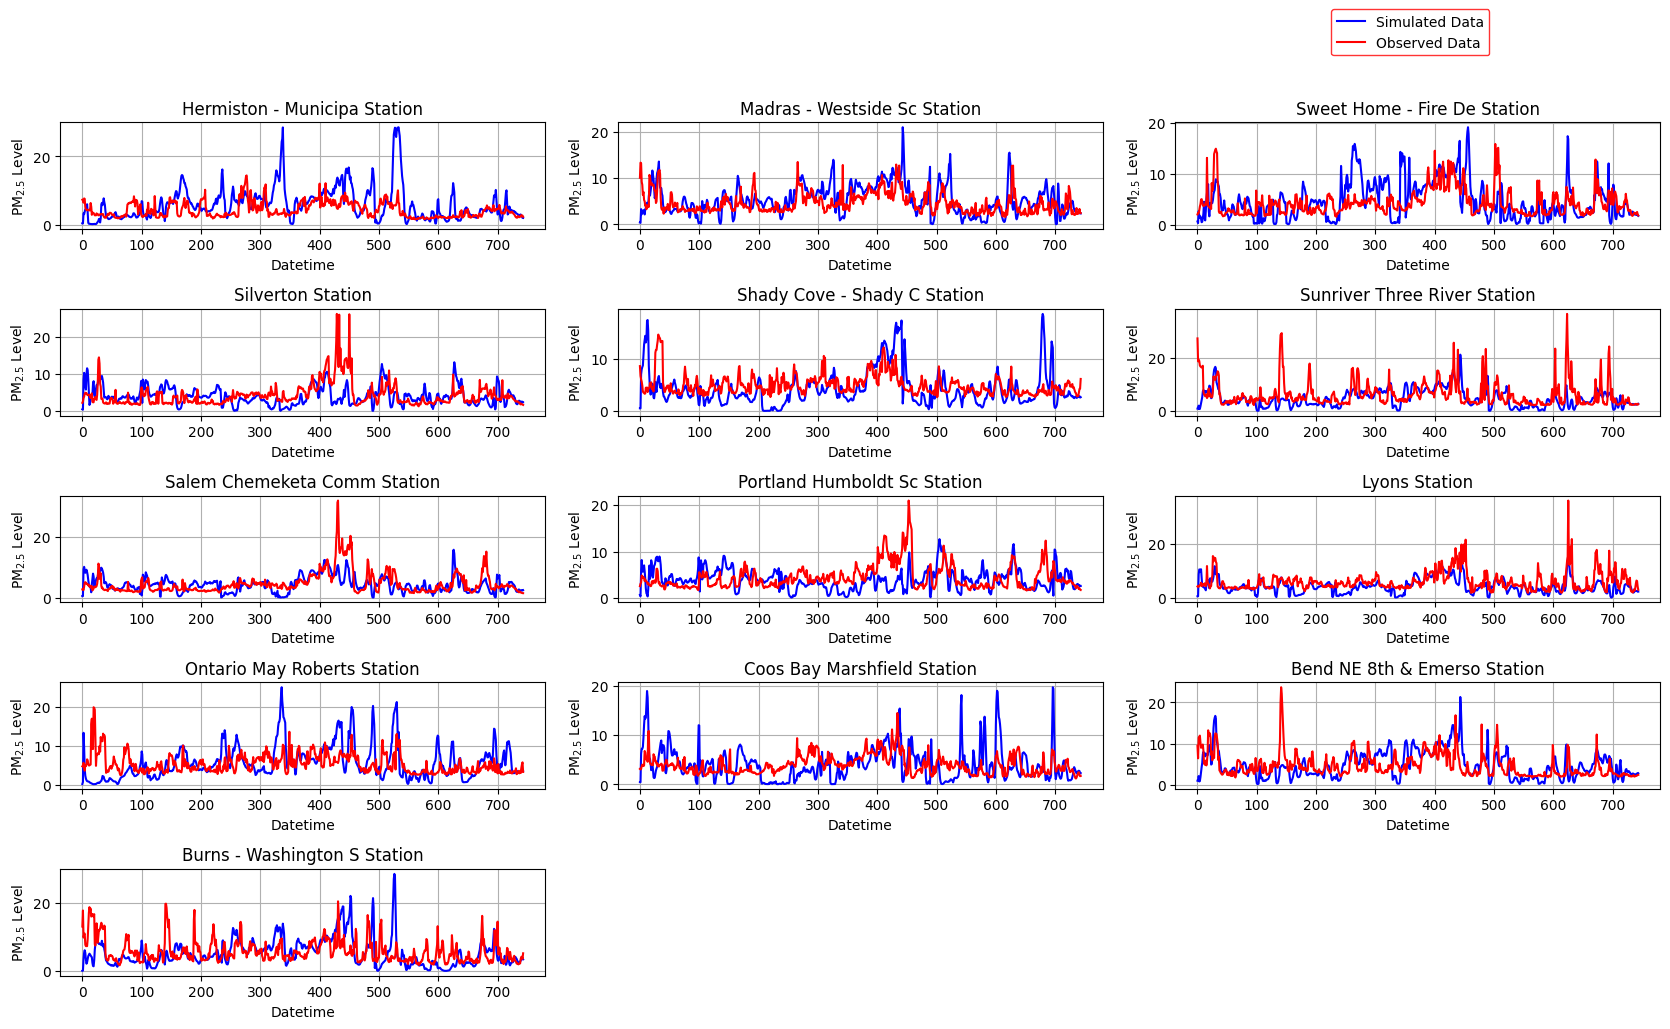

In [30]:
fig = plt.figure(figsize=(20, 20))
index_sub_plot = 1; dem = 0
ax, data, data_CMAQ = {}, {}, {}
df_errors = pd.DataFrame(columns=['R2', 'MSE', 'MAE', 'MB', 'RSR', 'RMSE', 'NMB', 'NME', 'PB', 'R'])

for index_tram in stations_test:
    df_verification = pd.DataFrame()
    ax[index_sub_plot] = fig.add_subplot(9, 3, index_sub_plot)
    not_selected_hours = []

    data_thuc_do = []
    data_mo_hinh = []

    for column in real_df_test.columns:
        try:
            if not math.isnan(real_df_test[column][index_tram]):
                data_thuc_do.append(real_df_test[column][index_tram])
                data_mo_hinh.append(simulated_df_test[column][index_tram])
        except:
            continue

    observed = data_thuc_do
    simulated = a * data_mo_hinh**b
    r2 = coefficient_of_determination(observed, simulated)
    mse = root_mean_squared_error(observed, simulated)
    mae = mean_absolute_error(observed, simulated)
    mb = mean_bias(observed, simulated)
    rsr = root_mean_square_error_ratio(observed, simulated)
    rmse = root_mean_squared_error(observed, simulated)
    nmb = normalized_mean_bias(observed, simulated)
    nme = normalized_mean_error(observed, simulated)
    pb = percent_bias(observed, simulated)
    r = correlation_coefficient(observed, simulated)
    df_errors.loc[index_tram] = [r2, mse, mae, mb, rsr, rmse, nmb, nme, pb, r]

    ax[index_sub_plot].plot(simulated, color='blue', label='Simulated Data')
    ax[index_sub_plot].plot(observed, color='red', label='Observed Data')
    ax[index_sub_plot].set_xlabel('Datetime')
    ax[index_sub_plot].set_ylabel('PM$_{2.5}$ Level')
    ax[index_sub_plot].set_title(f'{index_tram} Station')
    ax[index_sub_plot].grid(True)
    index_sub_plot += 1
    dem += 1

    df_verification.to_excel(f'{CALIBRATION_PATH}/Result/2_Excel/Verification_{index_tram}.xlsx')


handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.46, 0.55, 0.5), edgecolor='red')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.75)
# plt.suptitle(f"Comparison of Simulated and Observed PM$_{2.5}$ Concentrations After Calibration - {month_string} 2023", weight="bold", fontsize=12, y=0.95)
plt.show()
fig.savefig(f'{CALIBRATION_PATH}/Result/4_Diagram/Verification.png', dpi=500, format='png')
plt.close()

In [31]:
output_files = {
    f'{CALIBRATION_PATH}/Result/2_Excel/Calibration_Multiplier.xlsx': df_multiplier,
    f'{CALIBRATION_PATH}/Result/2_Excel/Calibration_Simulated_HieuChinh.xlsx': PM25_df_hieuchinh,
    f'{CALIBRATION_PATH}/Result/2_Excel/Calibration_Simulated.xlsx': PM25_datamodel,
    f'{CALIBRATION_PATH}/Result/2_Excel/Calibration_Average.xlsx': df_average,
    f'{CALIBRATION_PATH}/Result/2_Excel/Errors.xlsx': df_errors
}
for path, dataframe in output_files.items():
    dataframe.to_excel(path)

In [32]:
def find_nearest_multiplier(current_day, df):
    multiplier_days = df.columns; min_diff = float('inf'); nearest_day = None
    for day in multiplier_days:
        diff = abs(int(day[:2])*24 - int(int(current_day[:2])*24 + int(current_day[5:7])))
        if diff < min_diff:
            min_diff = diff; nearest_day = day
            
    return df.loc['Multiplier', nearest_day]

In [33]:
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
df = pd.read_excel(fr"{CALIBRATION_PATH}/Result/2_Excel/Calibration_Multiplier.xlsx", index_col=0)
df_lon = pd.read_excel(fr"{CALIBRATION_PATH}/Result/2_Excel/COORLON.xlsx")
df_lat = pd.read_excel(fr"{CALIBRATION_PATH}/Result/2_Excel/COORLAT.xlsx")
print(df.head())

column_names, column_min_max, column_cell = ['ROW', 'COL', 'LON', 'LAT'], [], ['ROW', 'COL', 'LON', 'LAT']
hours = [str(i).zfill(2) for i in range(24)]
days_months = [f'{str(day).zfill(2)}{month_number}' for day in range(1, day+1)]
column_names.extend(f'{day}-{hour}h' for day in days_months for hour in hours)
column_min_max.extend(f'{day}-{hour}h' for day in days_months for hour in hours)
df_multiplier = pd.DataFrame(columns=column_names)
df_min_max = pd.DataFrame(columns = column_min_max)
df_cell = pd.DataFrame(columns=column_cell)
print(df_min_max)

path_tiff_files = fr'{CALIBRATION_PATH}/Result/1_GeoTIFF/'
raw_name = os.listdir(path_tiff_files)
outnames = []
for rname in raw_name:
    portion = os.path.splitext(rname)
    temp_name = portion[0] + '.TIFF'
    outnames.append(temp_name)
arcpy.env.overwriteOutput = True
arcpy.env.workspace = path_tiff_files
rasters = arcpy.ListRasters("*", "All")


column_names_df = []
for col in df.columns:
    if (len(col[5:]) == 2):
        col = col[:5] + str(col[5:6]).zfill(2)
    column_names_df.append(col)
df.columns = column_names_df
df = df.reindex(sorted(df.columns), axis=1)



date_str = np.array(df.columns)
num_day, max_day = 0, date_str.size
value_min, value_max, value_average, value_cell = [], [], [], []
for raster in rasters:
    raster_tiff = rasterio.open(os.path.join(path_tiff_files, raster))
    PM25 = raster_tiff.read(1)
    row, col, value = [], [], []
    for i in range(PM25.shape[0]):
        for j in range(PM25.shape[1]):
            value.append(PM25[i][j])
            row.append(i)
            col.append(j)
    months_standard = int(date_str[num_day][2:4])
    days_standard = int(date_str[num_day][:2])
    parts = raster.split("_")
    hours = int(parts[2][0:2])
    days = int(parts[1][0:2])
    months = int(parts[1][2:4])
    date_raster = parts[1][0:2] + parts[1][2:4]
    date_hour_raster = date_raster + '-' + parts[2][0:2] + 'h'
    print(date_hour_raster, hours, days, months, num_day)
    df_multiplier['ROW'], df_multiplier['COL'] = row, col
    df_cell['ROW'], df_cell['COL'] = row, col
    df_multiplier[date_hour_raster], df_cell[date_hour_raster] = value, value
    df_cell['LON'], df_cell['LAT'] = df_lon["value"].values, df_lat["value"].values
    df_multiplier['LON'], df_multiplier['LAT'] = df_lon["value"].values, df_lat["value"].values

    try:
        df_multiplier[date_hour_raster] = df_multiplier[date_hour_raster] * df.loc['Multiplier', date_hour_raster]
    except:
        nearest_multiplier = find_nearest_multiplier(date_hour_raster, df)
        df_multiplier[date_hour_raster] = df_multiplier[date_hour_raster] * nearest_multiplier
    df_multiplier[date_hour_raster] = a*df_multiplier[date_hour_raster]**b
    df_cell[date_hour_raster] = df_multiplier[date_hour_raster]

    dem = 0
    for i in range(PM25.shape[0]):
        for j in range(PM25.shape[1]):
            PM25[i][j] = df_multiplier[date_hour_raster][dem]
            dem = dem + 1
    value_min.append(np.min(PM25))
    value_max.append(np.max(PM25))
    value_average.append(np.mean(PM25))

    metadata = raster_tiff.meta
    transform = metadata['transform']
    metadata.update({
        'dtype': PM25.dtype,
        'count': 1,
        'height': PM25.shape[0],
        'width': PM25.shape[1],
        'transform': transform
    })
    output_tiff = fr"{CALIBRATION_PATH}/Result/5_GeoTIFF_Calibrated\{date_hour_raster}.tiff"
    with rasterio.open(output_tiff, 'w', **metadata) as dst:
        dst.write(PM25, 1)

    print('-'*50)

print(df_cell)
print(df_min_max.shape)
value_min = np.array(value_min)
print(value_min.shape)
df_min_max.loc['Min'] = value_min
df_min_max.loc['Max'] = value_max
df_min_max.loc['Average'] = value_average

outExcelDir = f"{CALIBRATION_PATH}/Result/2_Excel/"
df_cell.to_excel(outExcelDir + 'Cell.xlsx', index = False)
df_min_max.to_excel(outExcelDir + 'Hourly_Average.xlsx', index = False)
df_multiplier.to_excel(outExcelDir + 'Multiplier.xlsx', index = False)

                 0103-00h   0103-01h   0103-02h   0103-03h   0103-04h  \
Observed Mean    6.440437   6.128050   6.328824   6.851739   6.841848   
Simulated Mean   0.506589   0.417229   0.319402   0.296987   0.280316   
Multiplier      12.713347  14.687505  19.814595  23.070812  24.407656   

                 0103-05h   0103-06h   0103-07h   0103-08h   0103-09h  ...  \
Observed Mean    6.456427   6.375934   6.319596   6.084667   6.027079  ...   
Simulated Mean   0.269538   0.221081   0.196738   0.173626   0.155803  ...   
Multiplier      23.953649  28.839746  32.121834  35.044749  38.684002  ...   

                 3103-14h   3103-15h   3103-16h   3103-17h   3103-18h  \
Observed Mean    2.377768   2.329177   2.226198   2.304332   2.417016   
Simulated Mean   0.125582   0.130972   0.138947   0.142878   0.141419   
Multiplier      18.933981  17.783810  16.021944  16.127974  17.091211   

                 3103-19h   3103-20h   3103-21h   3103-22h   3103-23h  
Observed Mean    2.443122   2